In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data=pd.read_csv("victoria_electricity_demand.csv",usecols=["demand", "temperature", "date_time"]
                 ,parse_dates=["date_time"],index_col=["date_time"])

In [4]:
data.head()

,demand,temperature
date_time,,
2002-01-01 00:00:00,6919.366092,32.6
2002-01-01 01:00:00,7165.974188,32.6
2002-01-01 02:00:00,6406.542994,32.6
2002-01-01 03:00:00,5815.537828,32.6
2002-01-01 04:00:00,5497.732922,32.6


In [5]:
data=data.loc["2010":]

In [6]:
data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,8314.448682,21.525
2010-01-01 01:00:00,8267.187296,22.400
2010-01-01 02:00:00,7394.528444,22.150
2010-01-01 03:00:00,6952.047520,21.800
2010-01-01 04:00:00,6867.199634,20.250


## Exponential weight for rolling windows features

In [7]:
df=data.copy()

In [12]:
def exp_weights(alpha,window_size):
    weights=np.ones(window_size)
    for ix in range (window_size):
        weights[ix]=(1-alpha)**(window_size-1-ix)
    return weights

In [13]:
exp_weights(alpha=0.05, window_size=12)

array([0.56880009, 0.59873694, 0.63024941, 0.66342043, 0.6983373 ,
       0.73509189, 0.77378094, 0.81450625, 0.857375  , 0.9025    ,
       0.95      , 1.        ])

In [14]:
def exp_weighted_mean(x):
    weights = exp_weights(alpha=0.05, window_size=len(x))
    return (weights * x).sum() / weights.sum()

In [16]:
roll=(
df["demand"].
    rolling(window=24*7)
    .agg(["mean", exp_weighted_mean]) #  statistics.
    .shift(freq="1H")
)
roll=roll.add_prefix("demand_window_168_")
roll

,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,
2010-01-01 01:00:00,NaN,NaN
2010-01-01 02:00:00,NaN,NaN
2010-01-01 03:00:00,NaN,NaN
2010-01-01 04:00:00,NaN,NaN
2010-01-01 05:00:00,NaN,NaN
...,...,...
2015-02-28 20:00:00,9654.616819,9270.767464
2015-02-28 21:00:00,9638.018555,9251.365371
2015-02-28 22:00:00,9624.108291,9204.788983


In [18]:
df = df.join(roll, how="left")
df

,demand,temperature,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9670.463454,9253.634423
2015-02-28 20:00:00,8883.230296,22.200,9654.616819,9270.767464
2015-02-28 21:00:00,8320.260550,18.900,9638.018555,9251.365371


Text(0.5, 0, 'Time')

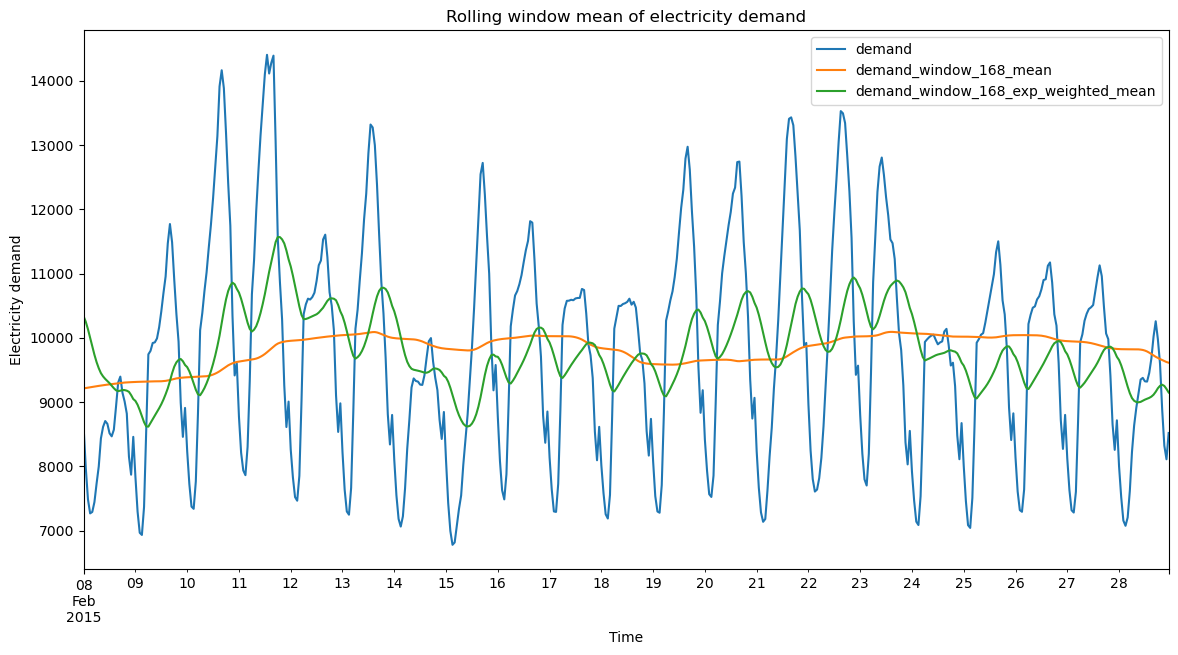

In [19]:
cols = ["demand",
        "demand_window_168_mean",
        "demand_window_168_exp_weighted_mean"]

ax = (
    df.iloc[-24 * 7 * 3 :] # last 3 weeks of data
      .loc[:, cols] #  columns wanted
      .plot(figsize=[14, 7])
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

## smoothing after detrending

In [21]:
from statsmodels.tsa.seasonal import MSTL

In [22]:
mstl=MSTL(
df["demand"],
    periods=[24,24*7],
    stl_kwargs={"seasonal_deg": 0})

res=mstl.fit()

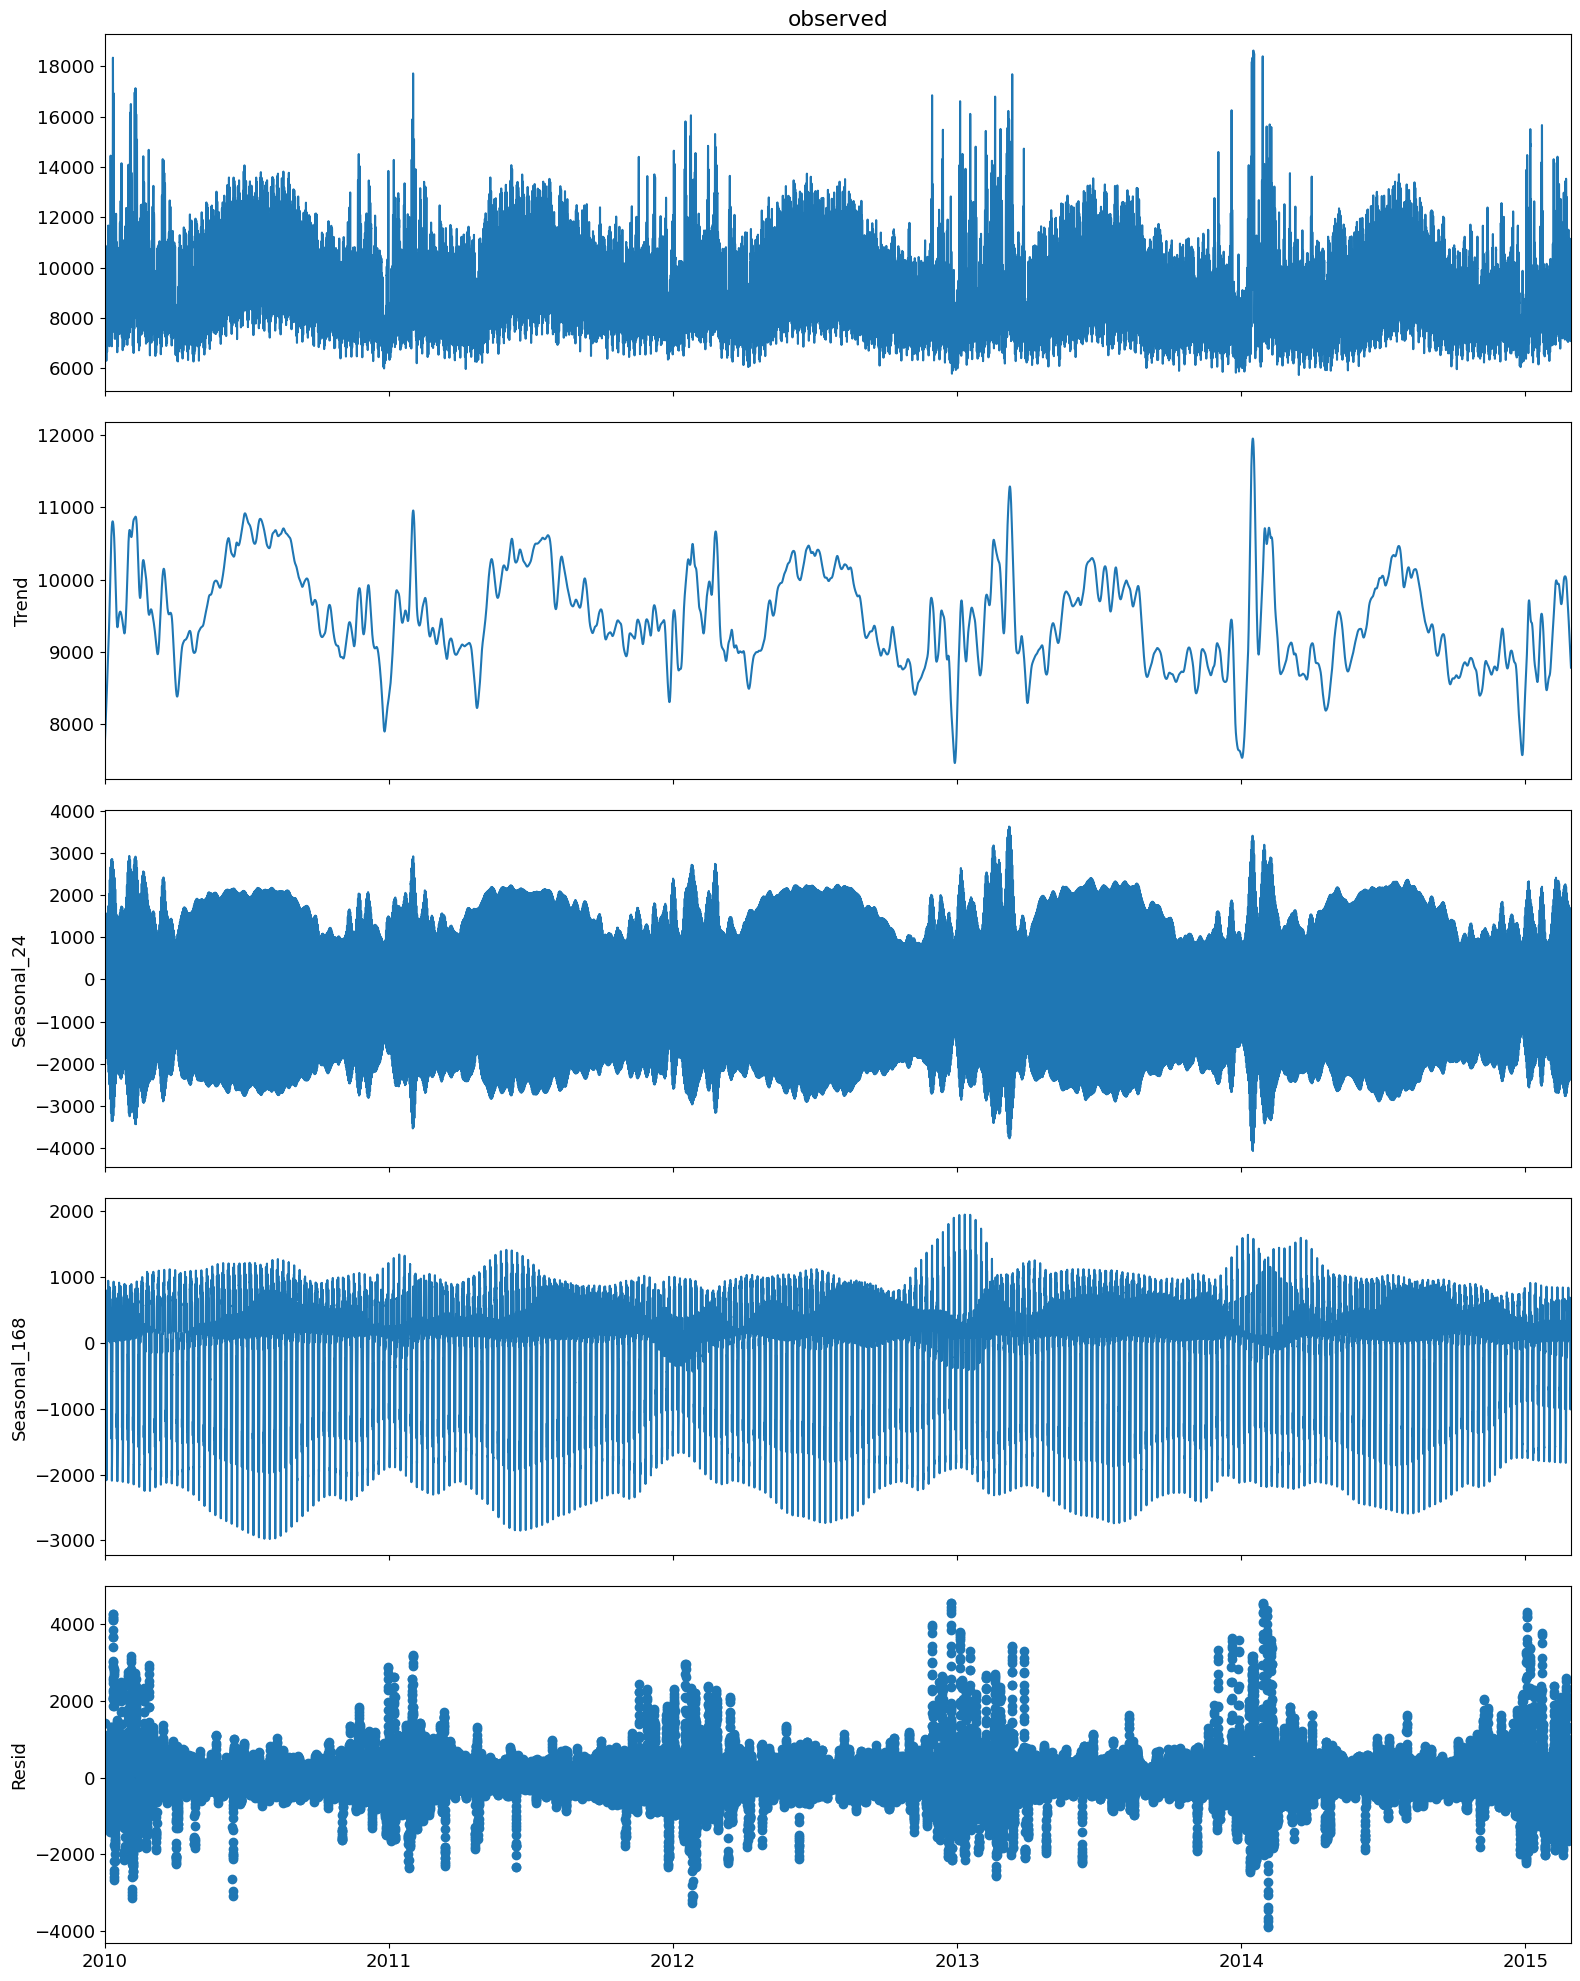

In [23]:
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

In [24]:
result = (
    res.trend # The trend component from MSTL.
    .rolling(window=24*7) 
    .agg(["mean", exp_weighted_mean]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.  
)

result = result.add_prefix("demand_window_168_")

# Join the window features back to the trend data
df = res.trend.to_frame().join(result, how='left')
df


,trend,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,,
2010-01-01 00:00:00,7672.016455,NaN,NaN
2010-01-01 01:00:00,7683.091900,NaN,NaN
2010-01-01 02:00:00,7694.177071,NaN,NaN
2010-01-01 03:00:00,7705.272092,NaN,NaN
2010-01-01 04:00:00,7716.377060,NaN,NaN
...,...,...,...
2015-02-28 19:00:00,8817.785857,9541.062328,8999.626058
2015-02-28 20:00:00,8808.736317,9533.775910,8990.522970
2015-02-28 21:00:00,8799.694076,9526.439463,8981.422484


Text(0.5, 0, 'Time')

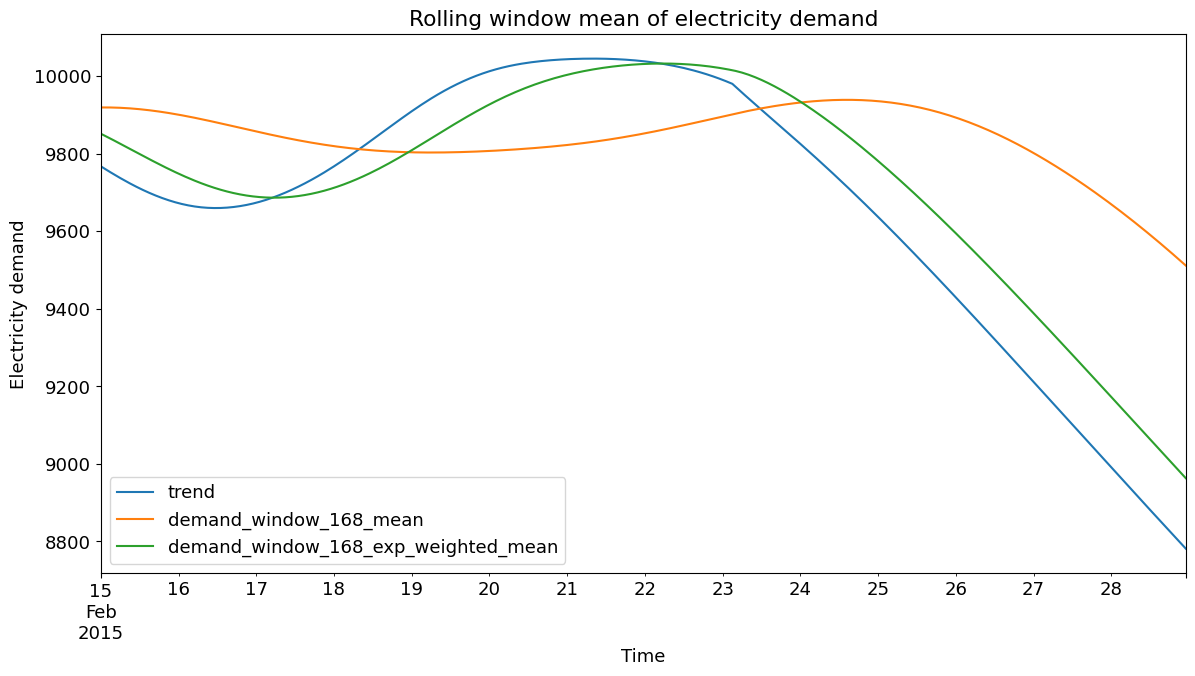

In [25]:
cols = ["trend",
        "demand_window_168_mean",
        "demand_window_168_exp_weighted_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
      .loc[:, cols] # Filter to columns of interest
      .plot(figsize=[14, 7])
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

### expandig window features with exponential weights 

In [26]:
df=data.copy()

In [27]:
res=(
df["demand"].
    ewm(alpha=0.05).
    agg(["mean","std"]).
    shift(freq="1H")
)
res = result.add_prefix("demand_ewm_0.05_")
res

,demand_ewm_0.05_demand_window_168_mean,demand_ewm_0.05_demand_window_168_exp_weighted_mean
date_time,,
2010-01-01 01:00:00,NaN,NaN
2010-01-01 02:00:00,NaN,NaN
2010-01-01 03:00:00,NaN,NaN
2010-01-01 04:00:00,NaN,NaN
2010-01-01 05:00:00,NaN,NaN
...,...,...
2015-02-28 20:00:00,9533.775910,8990.522970
2015-02-28 21:00:00,9526.439463,8981.422484
2015-02-28 22:00:00,9519.053405,8972.324835


In [28]:
df = df.join(result, how="left")
df

,demand,temperature,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9541.062328,8999.626058
2015-02-28 20:00:00,8883.230296,22.200,9533.775910,8990.522970
2015-02-28 21:00:00,8320.260550,18.900,9526.439463,8981.422484
